In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


rm -rf /shared/CSHL_data_processed/MD585/MD585_sorted_filenames.txt && mkdir -p /shared/CSHL_data_processed/MD585
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_sorted_filenames.txt /shared/CSHL_data_processed/MD585/MD585_sorted_filenames.txt
rm -rf /shared/CSHL_data_processed/MD585/MD585_anchor.txt && mkdir -p /shared/CSHL_data_processed/MD585
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_anchor.txt /shared/CSHL_data_processed/MD585/MD585_anchor.txt
rm -rf /shared/CSHL_data_processed/MD585/MD585_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD585
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropbox.txt /shared/CSHL_data_processed/MD585/MD585_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropbox.txt
rm -rf /shared/CSHL_data_processed/MD589/MD589_sorted_filenames.txt && mkdir -p /shared/CSHL_data_processe

rm -rf /shared/CSHL_data_processed/MD599/MD599_anchor.txt && mkdir -p /shared/CSHL_data_processed/MD599
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD599/MD599_anchor.txt /shared/CSHL_data_processed/MD599/MD599_anchor.txt
rm -rf /shared/CSHL_data_processed/MD599/MD599_alignedTo_MD599-IHC40-2015.10.03-06.04.31_MD599_2_0119_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD599
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD599/MD599_alignedTo_MD599-IHC40-2015.10.03-06.04.31_MD599_2_0119_cropbox.txt /shared/CSHL_data_processed/MD599/MD599_alignedTo_MD599-IHC40-2015.10.03-06.04.31_MD599_2_0119_cropbox.txt
rm -rf /shared/CSHL_data_processed/MD602/MD602_sorted_filenames.txt && mkdir -p /shared/CSHL_data_processed/MD602
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD602/MD602_sorted_filenames.txt /shared/CSHL_data_processed/MD602/MD602_sorted_filenames.txt
rm -rf /shared/CSHL_data_processed/MD602/MD602_anchor.txt && mkdir -p /shared/CSHL_data_processed/MD

rm -rf /shared/CSHL_data_processed/MD589/MD589_thumbnail_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC2-2015.07.30-21.32.04_MD589_2_0005_thumbnail_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_thumbnail_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_thumbnail_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC2-2015.07.30-21.32.04_MD589_2_0005_thumbnail_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_thumbnail_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC2-2015.07.30-21.32.04_MD589_2_0005_thumbnail_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif
rm -rf /shared/CSHL_data_processed/MD590/MD590_thumbnail_alignedTo_MD590-N47-2015.09.12-05.32.06_MD590_2_0140_cropped/MD590-IHC4-2015.08.1

rm -rf /shared/CSHL_data_processed/MD603/MD603_thumbnail_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped/MD603-IHC2-2015.12.03-13.34.22_MD603_2_0005_thumbnail_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD603/MD603_thumbnail_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD603/MD603_thumbnail_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped/MD603-IHC2-2015.12.03-13.34.22_MD603_2_0005_thumbnail_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped.tif /shared/CSHL_data_processed/MD603/MD603_thumbnail_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped/MD603-IHC2-2015.12.03-13.34.22_MD603_2_0005_thumbnail_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped.tif
rm -rf /shared/CSHL_data_processed/MD635/MD635_thumbnail_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropped/MD635-F4-2016.05.18-16.52.52_MD635

In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

# Sort structures

In [3]:
structures_sorted_by_size = ['4N', '6N', 'Amb', 'PBG', '10N', 'AP', '3N', 'LC', 'SNC', 'Tz', '7n', 'RMC', '5N', 'VCP', '12N', 'LRt', '7N', 'VCA', 'VLL', 'DC', 'Sp5O', 'Sp5I', 'Pn', 'RtTg', 'SNR', 'Sp5C', 'IC', 'SC']

x =[[s] if s in singular_structures else [convert_to_left_name(s), convert_to_right_name(s)] for s in structures_sorted_by_size]
structures_sided_sorted_by_size = [j for i in x for j in i ]
print structures_sided_sorted_by_size

['4N_L', '4N_R', '6N_L', '6N_R', 'Amb_L', 'Amb_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'AP', '3N_L', '3N_R', 'LC_L', 'LC_R', 'SNC_L', 'SNC_R', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'RMC_L', 'RMC_R', '5N_L', '5N_R', 'VCP_L', 'VCP_R', '12N', 'LRt_L', 'LRt_R', '7N_L', '7N_R', 'VCA_L', 'VCA_R', 'VLL_L', 'VLL_R', 'DC_L', 'DC_R', 'Sp5O_L', 'Sp5O_R', 'Sp5I_L', 'Sp5I_R', 'Pn_L', 'Pn_R', 'RtTg', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'IC', 'SC']


# Load test dataset

In [4]:
test_dataset_ids = [25, 29, 32, 35]

In [5]:
dataset_settings = read_csv(DATASET_SETTINGS_CSV, header=0, index_col=0)

In [6]:
# Read all classes in the given test datasets.

labels_to_sample = set([])

for dataset_id in test_dataset_ids:

    dataset_properties = dataset_settings.loc[dataset_id]

    classes = dataset_properties['classes'].split('/')
    num_samples_per_label = dataset_properties['num_sample_per_class']
    stacks = dataset_properties['stacks'].split('/')
    network_model = dataset_properties['network_model']
    stain = dataset_properties['stain']
    cell_features_used = dataset_properties['cell_features_used']

    if network_model is np.nan and cell_features_used is np.nan:
        print "Use raw image patches"
        
    ###################################

    structures_to_sample = all_known_structures

    negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

    margins_um = dataset_properties['margins_um']
    if isinstance(margins_um, np.float) and np.isnan(margins_um):
        margins_to_sample = []
    else:
        margins_to_sample = map(int, str(margins_um).split('/'))
    surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                                 for m in margins_to_sample
                                 for s in structures_to_sample 
                                 for surr_l in all_known_structures
                                 if surr_l != s]
    surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                                 for m in margins_to_sample
                                 for s in structures_to_sample]

    if 'pos' in classes:
        labels_to_sample |= set(structures_to_sample)
    if 'neg' in classes:
        labels_to_sample |= set(negative_labels_to_sample)
    if 'surPos' in classes:
        labels_to_sample |= set(surround_positive_labels_to_sample)
    if 'surNoclass' in classes:
        labels_to_sample |= set(surround_noclass_labels_to_sample)

In [ ]:
# or specify a set of classes
##############################

# structures_to_sample = all_known_structures

# negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# # margins_to_sample = [100,200,300,400,500,600,700,800,900,1000]
# margins_to_sample = [500]

# surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
#                              for m in margins_to_sample
#                              for s in structures_to_sample 
#                              for surr_l in all_known_structures
#                              if surr_l != s]

# surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
#                              for m in margins_to_sample
#                              for s in structures_to_sample]

# labels_to_sample = structures_to_sample + \
# surround_positive_labels_to_sample + surround_noclass_labels_to_sample + \
# negative_labels_to_sample

In [7]:
test_features, test_addresses = load_datasets(test_dataset_ids, labels_to_sample=labels_to_sample)

rm -rf /shared/CSHL_classifiers/datasets/dataset_25/patch_addresses.pkl && mkdir -p /shared/CSHL_classifiers/datasets/dataset_25
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_25/patch_addresses.pkl /shared/CSHL_classifiers/datasets/dataset_25/patch_addresses.pkl
rm -rf /shared/CSHL_classifiers/datasets/dataset_25/patch_features.hdf && mkdir -p /shared/CSHL_classifiers/datasets/dataset_25
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_25/patch_features.hdf /shared/CSHL_classifiers/datasets/dataset_25/patch_features.hdf
rm -rf /shared/CSHL_classifiers/datasets/dataset_29/patch_addresses.pkl && mkdir -p /shared/CSHL_classifiers/datasets/dataset_29
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_29/patch_addresses.pkl /shared/CSHL_classifiers/datasets/dataset_29/patch_addresses.pkl
rm -rf /shared/CSHL_classifiers/datasets/dataset_29/patch_features.hdf && mkdir -p /shared/CSHL_classifiers/datasets/dataset_29
aws s3 cp s3:/

In [8]:
assert set(test_addresses.keys()) == set(test_features.keys()), \
'Test features and test addresses are not consistent.'

In [9]:
labels_found = test_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found 
                        if convert_to_original_name(l) in labels_found]) - {'noclass'}

# Plot recall-precision

In [13]:
# fixed_n_pos = None
# fixed_n_neg = None
fixed_n_pos = 1000
fixed_n_neg = 1000

In [83]:
# This specifies what patches has Negative labels.
negative_composition_rules = ['surround200', 'surround500', 'surround1000', 'negative']

In [87]:
# classifier_ids = [37, 38, 39, 40, 41, 42]
classifier_ids = [38]

classifier_settings = read_csv(CLASSIFIER_SETTINGS_CSV, header=0, index_col=0)

acc_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
tp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
fn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
fp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
tn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
precision_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
recall_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
f1score_normalized_all_clfs_all_structures_all_negcomprule =  defaultdict(lambda: defaultdict(dict))

for classifier_id in classifier_ids:
    
    classifier_properties = classifier_settings.loc[classifier_id]    
    svm_id = classifier_properties['svm_id']

    clf_allClasses = {}
    for structure in structures_to_sample:
        clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
        download_from_s3(clf_fp)
        if os.path.exists(clf_fp):
            clf_allClasses[structure] = joblib.load(clf_fp)
        else:
            sys.stderr.write('Classifier for %s is not found.\n' % structure)

    ####################################################
    # Compute accuracy against each structure surround #
    ####################################################
    
    for neg_composition_rule in negative_composition_rules:
            
        ncols = 5
        nrows = int(np.ceil(len(structures_found)/float(ncols)))

    #     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
    #     axes = axes.flatten()

        for i, structure in enumerate(structures_found):

            features_pos = test_features[structure]
            if fixed_n_pos is not None:
                features_pos = features_pos[np.random.choice(range( len(features_pos)), replace=False, size=(min(fixed_n_pos, len(features_pos)),))]
            n_pos = len(features_pos)
            print structure, n_pos, 'positive'

            if neg_composition_rule.startswith('surround'):
                if neg_composition_rule == 'surround200':
                    margin_um = 200
                elif neg_composition_rule == 'surround500':
                    margin_um = 500
                elif neg_composition_rule == 'surround1000':
                    margin_um = 1000
                else:
                    margin_um = None
                neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')] + \
                [convert_to_surround_name(structure, margin=margin_um, suffix=surr_l) for surr_l in structures_found]
            elif neg_composition_rule == 'negative':
                neg_classes = [structure + '_negative']
            else:
                raise
            
            neg_classes = list(set(neg_classes) & set(labels_found))

            features_neg = np.vstack([test_features[neg_class] for neg_class in neg_classes])
            if fixed_n_neg is not None:
                features_neg = features_neg[np.random.choice(range( len(features_neg)), replace=False, size=(min(fixed_n_neg, len(features_neg)),))]

            n_neg = len(features_neg)
            print structure, n_neg, 'negative'

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            if structure not in clf_allClasses:
                sys.stderr.write('Classifier for structure %s does not exist.\n' %  structure)
                continue

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            
            
            ######### SOFT ########
            cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                             normalize=False)
            tp = cm[0,0]
            fn = cm[0,1]
            fp = cm[1,0]
            tn = cm[1,1]

            acc = (tp + tn) / (n_pos + n_neg)
            acc_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = acc

            tp_normalized = tp / n_pos
            fn_normalized = fn / n_pos
            fp_normalized = fp / n_neg
            tn_normalized = tn / n_neg

            tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tp_normalized
            fn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fn_normalized
            fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fp_normalized
            tn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tn_normalized

            ######## PRECISION-RECALL ########
            precision_allthresh = {}
            recall_allthresh = {}
            f1score_allthresh = {}
            for th in np.arange(0., 1., 0.01):
            
                cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=False,
                                             normalize=False, binary=True, decision_thresh=th)

                tp = cm[0,0]
                fn = cm[0,1]
                fp = cm[1,0]
                tn = cm[1,1]
                
                precision = float(tp) / (tp + fp)
                recall = float(tp) / (tp + fn)
                f1score = 2*recall*precision/(recall+precision)
                
                precision_allthresh[th] = precision
                recall_allthresh[th] = recall
                f1score_allthresh[th] = f1score
                
            precision_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = precision_allthresh
            recall_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = recall_allthresh
            f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = f1score_allthresh
    #     plt.tight_layout()

        ############################

#         xticks = range(1, 1 + len(structures_sorted_by_size))

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [acc_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size]);
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylim([0.6, 1]);
#         plt.ylabel('Accuracy');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.show();

#         print 'test accuracy:', np.mean(acc_all_clfs_all_structures[classifier_id].values())

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [tp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tp', markerfmt='bo');
#         plt.stem(xticks, [fn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fn', markerfmt='ro');
#         plt.stem(xticks, [fp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fp', markerfmt='ko');
#         plt.stem(xticks, [tn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tn', markerfmt='go');
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylabel('Percentage');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.legend();
#         plt.show();

tp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
fn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
fp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
tn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
precision_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
recall_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
f1score_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None

rm -rf /shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump && mkdir -p /shared/CSHL_classifiers/setting_38/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump /shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump


Classifier for sp5 is not found.


rm -rf /shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump && mkdir -p /shared/CSHL_classifiers/setting_38/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump /shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump


Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in double_scalars


7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 pos

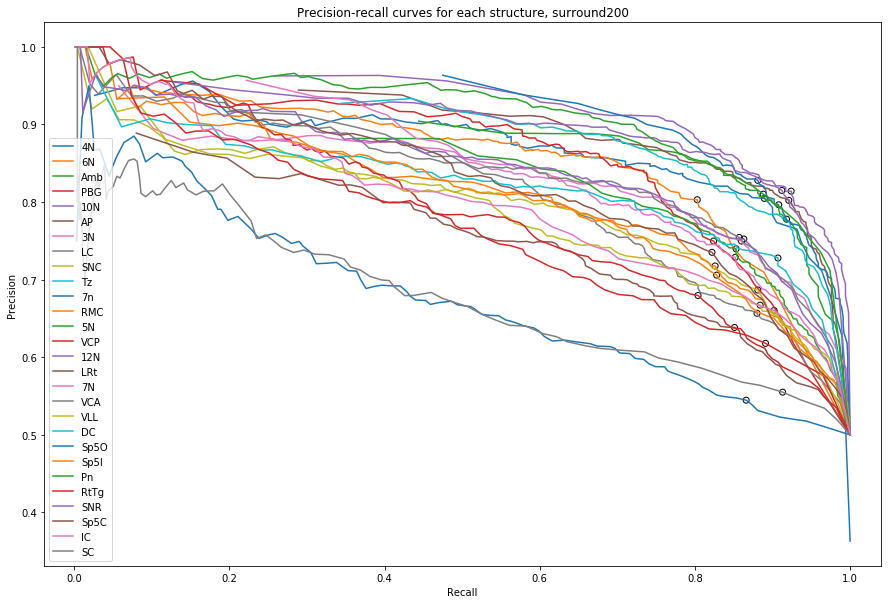

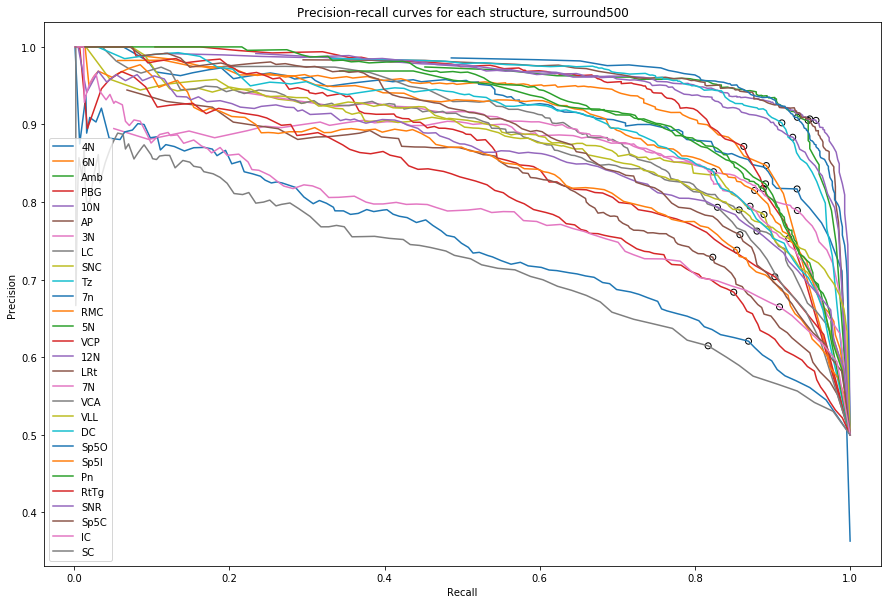

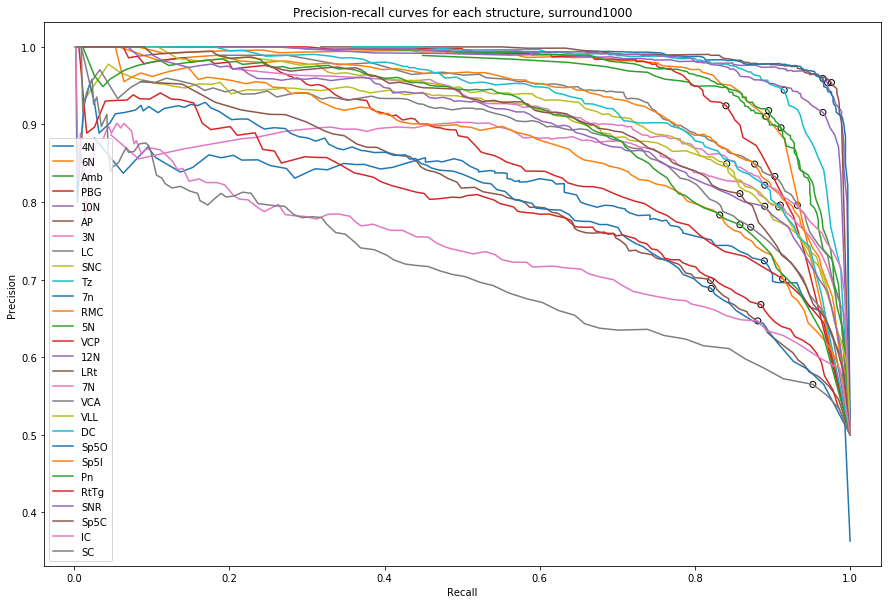

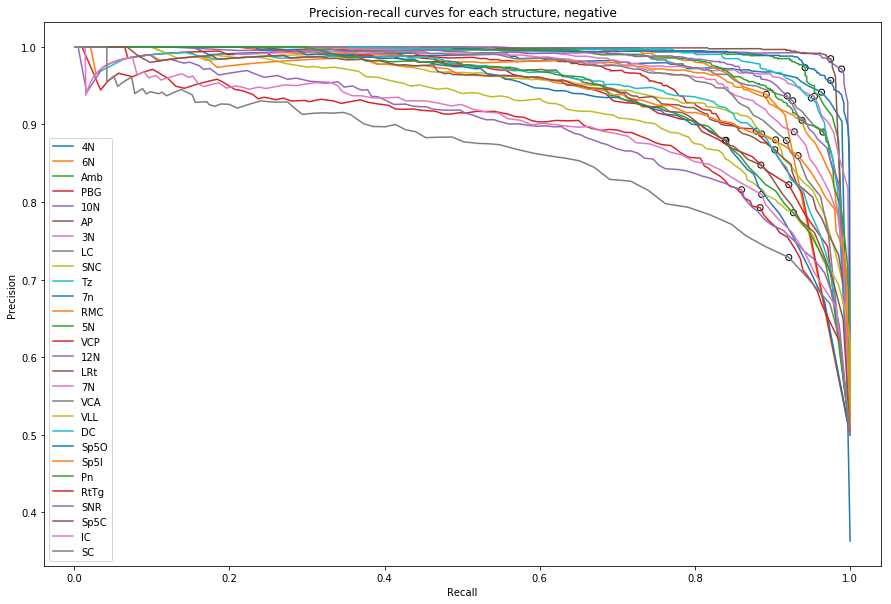

In [126]:
for neg_composition_rule in negative_composition_rules:

    plt.figure(figsize=(15, 10));
    for s in structures_sorted_by_size:
        r = recall_normalized_all_clfs_all_structures_all_negcomprule[38][s][neg_composition_rule]
        p = precision_normalized_all_clfs_all_structures_all_negcomprule[38][s][neg_composition_rule]
        f = f1score_normalized_all_clfs_all_structures_all_negcomprule[38][s][neg_composition_rule]
        plt.plot([r[th] for th in np.arange(0, 1, 0.01)],
                 [p[th] for th in np.arange(0, 1, 0.01)],
                label=s);

        optimal_th = np.arange(0, 1, 0.01)[np.nanargmax([f[th] for th in np.arange(0, 1, 0.01)])]
        plt.scatter(r[optimal_th], p[optimal_th], marker='o', facecolors='none', edgecolors='k')

    plt.legend();
    plt.axis('equal');
    plt.ylabel('Precision');
    plt.xlabel('Recall');
    plt.title('Precision-recall curves for each structure, %s' % (neg_composition_rule));
    plt.show();

# Compare different classifiers

In [10]:
# fixed_n_pos = None
# fixed_n_neg = None
fixed_n_pos = 1000
fixed_n_neg = 1000

In [11]:
# This specifies what patches has Negative labels.
negative_composition_rules = ['surround200', 'surround500', 'surround1000', 'negative']

In [134]:
classifier_ids = [37, 38, 39, 40, 41, 42]

classifier_settings = read_csv(CLASSIFIER_SETTINGS_CSV, header=0, index_col=0)

acc_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
tp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
fn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
fp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
tn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))

for classifier_id in classifier_ids:
    
    classifier_properties = classifier_settings.loc[classifier_id]    
    svm_id = classifier_properties['svm_id']

    clf_allClasses = {}
    for structure in structures_to_sample:
        clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
        download_from_s3(clf_fp)
        if os.path.exists(clf_fp):
            clf_allClasses[structure] = joblib.load(clf_fp)
        else:
            sys.stderr.write('Classifier for %s is not found.\n' % structure)

    ####################################################
    # Compute accuracy against each structure surround #
    ####################################################
    
    for neg_composition_rule in negative_composition_rules:
            
        ncols = 5
        nrows = int(np.ceil(len(structures_found)/float(ncols)))

    #     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
    #     axes = axes.flatten()

        for i, structure in enumerate(structures_found):

            features_pos = test_features[structure]
            if fixed_n_pos is not None:
                features_pos = features_pos[np.random.choice(range( len(features_pos)), replace=False, size=(min(fixed_n_pos, len(features_pos)),))]
            n_pos = len(features_pos)
            print structure, n_pos, 'positive'

            if neg_composition_rule.startswith('surround'):
                if neg_composition_rule == 'surround200':
                    margin_um = 200
                elif neg_composition_rule == 'surround500':
                    margin_um = 500
                elif neg_composition_rule == 'surround1000':
                    margin_um = 1000
                else:
                    margin_um = None
                neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')] + \
                [convert_to_surround_name(structure, margin=margin_um, suffix=surr_l) for surr_l in structures_found]
            elif neg_composition_rule == 'negative':
                neg_classes = [structure + '_negative']
            else:
                raise
            
            neg_classes = list(set(neg_classes) & set(labels_found))

            features_neg = np.vstack([test_features[neg_class] for neg_class in neg_classes])
            if fixed_n_neg is not None:
                features_neg = features_neg[np.random.choice(range( len(features_neg)), replace=False, size=(min(fixed_n_neg, len(features_neg)),))]

            n_neg = len(features_neg)
            print structure, n_neg, 'negative'

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            if structure not in clf_allClasses:
                sys.stderr.write('Classifier for structure %s does not exist.\n' %  structure)
                continue

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)

    #         plot_confusion_matrix(cm, title='%(structure)s vs\nAll surround %(margin_um)d'% {'structure':structure, 'margin_um':margin_um},
    #                               labels=['',''], xlabel='', ylabel='',
    #                              axis=axes[i])

            tp = cm[0,0]
            fn = cm[0,1]
            fp = cm[1,0]
            tn = cm[1,1]

            acc = (tp + tn) / (n_pos + n_neg)
            acc_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = acc

            tp_normalized = tp / n_pos
            fn_normalized = fn / n_pos
            fp_normalized = fp / n_neg
            tn_normalized = tn / n_neg

            tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tp_normalized
            fn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fn_normalized
            fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fp_normalized
            tn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tn_normalized

    #     plt.tight_layout()

        ############################

#         xticks = range(1, 1 + len(structures_sorted_by_size))

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [acc_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size]);
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylim([0.6, 1]);
#         plt.ylabel('Accuracy');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.show();

#         print 'test accuracy:', np.mean(acc_all_clfs_all_structures[classifier_id].values())

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [tp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tp', markerfmt='bo');
#         plt.stem(xticks, [fn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fn', markerfmt='ro');
#         plt.stem(xticks, [fp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fp', markerfmt='ko');
#         plt.stem(xticks, [tn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tn', markerfmt='go');
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylabel('Percentage');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.legend();
#         plt.show();

tp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
fn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
fp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
tn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None

rm -rf /shared/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump


Child returned 0
Child returned 1
0.42 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump


Child returned 1
0.43 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump /shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump


Child returned 1
0.43 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump && mkdir -p /shared/CSHL_classifiers/setting_38/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump /shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump


Child returned 1
0.43 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_39/classifiers/sp5_clf_setting_39.dump /shared/CSHL_classifiers/setting_39/classifiers/sp5_clf_setting_39.dump


Child returned 1
0.43 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_39/classifiers/outerContour_clf_setting_39.dump && mkdir -p /shared/CSHL_classifiers/setting_39/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_39/classifiers/outerContour_clf_setting_39.dump /shared/CSHL_classifiers/setting_39/classifiers/outerContour_clf_setting_39.dump


Child returned 1
0.44 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_40/classifiers/sp5_clf_setting_40.dump /shared/CSHL_classifiers/setting_40/classifiers/sp5_clf_setting_40.dump


Child returned 1
0.43 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_40/classifiers/outerContour_clf_setting_40.dump && mkdir -p /shared/CSHL_classifiers/setting_40/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_40/classifiers/outerContour_clf_setting_40.dump /shared/CSHL_classifiers/setting_40/classifiers/outerContour_clf_setting_40.dump


Child returned 1
0.43 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_41/classifiers/sp5_clf_setting_41.dump /shared/CSHL_classifiers/setting_41/classifiers/sp5_clf_setting_41.dump


Child returned 1
0.43 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_41/classifiers/outerContour_clf_setting_41.dump && mkdir -p /shared/CSHL_classifiers/setting_41/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_41/classifiers/outerContour_clf_setting_41.dump /shared/CSHL_classifiers/setting_41/classifiers/outerContour_clf_setting_41.dump


Child returned 1
0.43 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_42/classifiers/sp5_clf_setting_42.dump /shared/CSHL_classifiers/setting_42/classifiers/sp5_clf_setting_42.dump


Child returned 1
0.45 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_42/classifiers/outerContour_clf_setting_42.dump && mkdir -p /shared/CSHL_classifiers/setting_42/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_42/classifiers/outerContour_clf_setting_42.dump /shared/CSHL_classifiers/setting_42/classifiers/outerContour_clf_setting_42.dump


Child returned 1
0.47 seconds.
Classifier for outerContour is not found.


Tz 1000 positive
Tz 1000 negative
Sp5O 1000 positive
Sp5O 1000 negative
7n 1000 positive
7n 1000 negative
DC 1000 positive
DC 1000 negative
5N 1000 positive
5N 1000 negative
3N 1000 positive
3N 1000 negative
Pn 1000 positive
Pn 1000 negative
10N 1000 positive
10N 1000 negative
LC 1000 positive
LC 1000 negative
7N 1000 positive
7N 1000 negative
Amb 1000 positive
Amb 1000 negative
12N 1000 positive
12N 1000 negative
RMC 1000 positive
RMC 1000 negative
VCA 1000 positive
VCA 1000 negative
Sp5I 1000 positive
Sp5I 1000 negative
Sp5C 1000 positive
Sp5C 1000 negative
4N 570 positive
4N 1000 negative
AP 1000 positive
AP 1000 negative
PBG 1000 positive
PBG 1000 negative
LRt 1000 positive
LRt 1000 negative
IC 1000 positive
IC 1000 negative
VLL 1000 positive
VLL 1000 negative
VCP 1000 positive
VCP 1000 negative
SNC 1000 positive
SNC 1000 negative
6N 1000 positive
6N 1000 negative
SNR 1000 positive
SNR 1000 negative
SC 1000 positive
SC 1000 negative
RtTg 1000 positive
RtTg 1000 negative
Tz 1000 pos

In [135]:
classifier_colors = dict(zip(classifier_ids, np.array(random_colors(len(classifier_ids)))/255.))

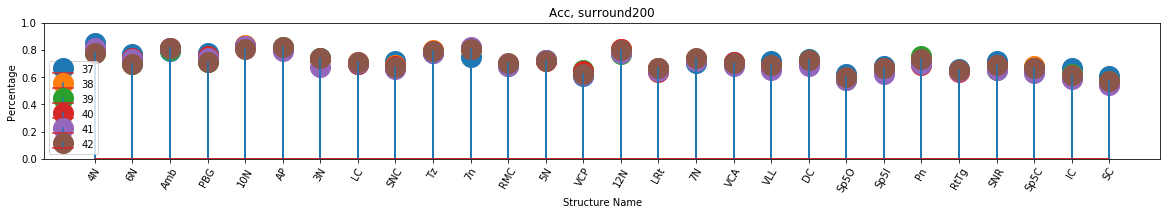

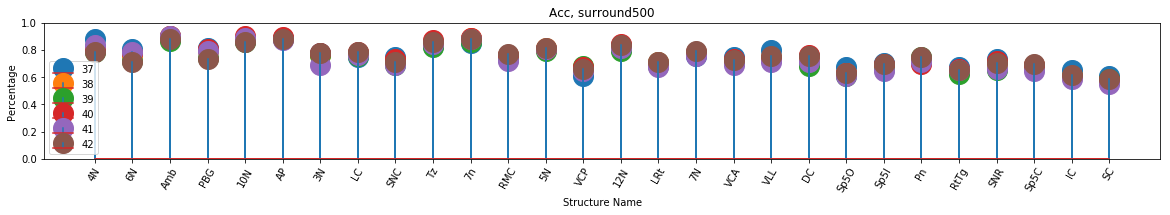

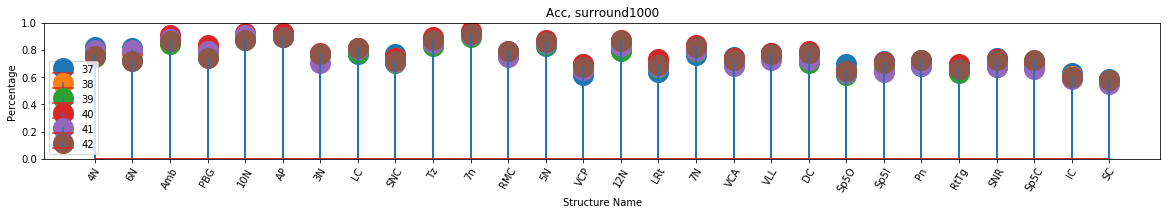

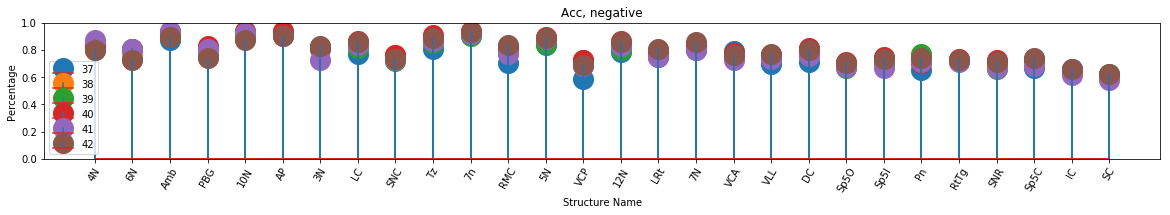

In [196]:
xticks = range(1, 1 + len(structures_sorted_by_size))

for neg_composition_rule in negative_composition_rules:

    plt.figure(figsize=(20, 2.5));
    
    for classifier_id in classifier_ids:
        
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                 [acc_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                  for s in structures_sorted_by_size],
                 label=classifier_id, markerfmt='o', mc=classifier_colors[classifier_id], markevery=[4,8]);
        plt.setp(markerLines, markersize=20, alpha=1.)
    plt.xticks(xticks, structures_sorted_by_size, rotation='60');
    plt.ylabel('Percentage');
    plt.xlabel('Structure Name');
    plt.title('Acc, %s' % (neg_composition_rule));
    plt.ylim([0, 1.]);
    plt.legend();
    plt.show();

In [194]:
# Best classifier for each structure

for neg_composition_rule in negative_composition_rules:
    best_classifier_id_all_structures = [(s, classifier_ids[np.argmax([acc_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
                                                                      for classifier_id in classifier_ids])])
                                         for s in structures_sorted_by_size]
    print neg_composition_rule
    print best_classifier_id_all_structures
    print

surround200
[('4N', 37), ('6N', 37), ('Amb', 40), ('PBG', 37), ('10N', 38), ('AP', 42), ('3N', 42), ('LC', 42), ('SNC', 37), ('Tz', 38), ('7n', 41), ('RMC', 42), ('5N', 41), ('VCP', 39), ('12N', 38), ('LRt', 42), ('7N', 42), ('VCA', 37), ('VLL', 37), ('DC', 37), ('Sp5O', 37), ('Sp5I', 37), ('Pn', 39), ('RtTg', 37), ('SNR', 37), ('Sp5C', 38), ('IC', 37), ('SC', 37)]

surround500
[('4N', 37), ('6N', 37), ('Amb', 41), ('PBG', 37), ('10N', 40), ('AP', 40), ('3N', 37), ('LC', 42), ('SNC', 37), ('Tz', 40), ('7n', 40), ('RMC', 42), ('5N', 42), ('VCP', 39), ('12N', 40), ('LRt', 38), ('7N', 42), ('VCA', 37), ('VLL', 37), ('DC', 40), ('Sp5O', 37), ('Sp5I', 37), ('Pn', 39), ('RtTg', 37), ('SNR', 37), ('Sp5C', 42), ('IC', 37), ('SC', 37)]

surround1000
[('4N', 37), ('6N', 37), ('Amb', 40), ('PBG', 40), ('10N', 40), ('AP', 40), ('3N', 40), ('LC', 40), ('SNC', 37), ('Tz', 40), ('7n', 40), ('RMC', 42), ('5N', 40), ('VCP', 39), ('12N', 40), ('LRt', 40), ('7N', 40), ('VCA', 37), ('VLL', 37), ('DC', 40)

In [195]:
# Average acc over all structures

for neg_composition_rule in negative_composition_rules:
    average_acc_all_classifiers = [(classifier_id, np.mean([acc_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
                                                                      for s in structures_sorted_by_size]))
                                         for classifier_id in classifier_ids]
    print neg_composition_rule
    print sorted(average_acc_all_classifiers, key=lambda x: x[1], reverse=True)
    print

surround200
[(37, 0.7215965419893301), (38, 0.71393268074660388), (42, 0.71265271812798225), (40, 0.71038473523854007), (39, 0.7070876397262521), (41, 0.69704819574960086)]

surround500
[(37, 0.76034453898863574), (40, 0.75830717399404979), (38, 0.753258958858119), (42, 0.75118363767537244), (41, 0.73365595684540441), (39, 0.73167551868391545)]

surround1000
[(40, 0.78013586599152818), (38, 0.76484987292655104), (42, 0.76097536418034561), (37, 0.75953142235952209), (41, 0.74414179337949682), (39, 0.73835068745567611)]

negative
[(40, 0.80275651191758945), (38, 0.79406783534595327), (42, 0.78943299014921819), (39, 0.77405466181903926), (41, 0.77093420195165319), (37, 0.75683688534592186)]



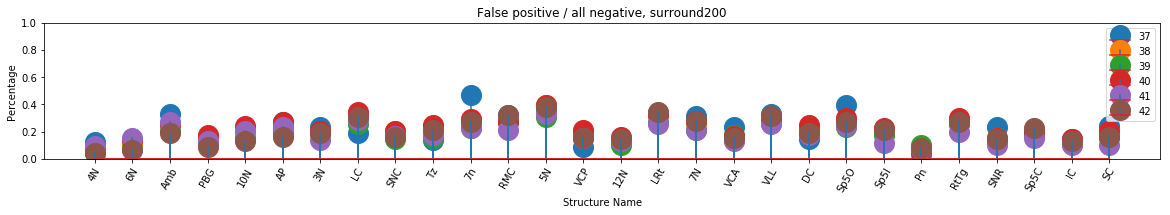

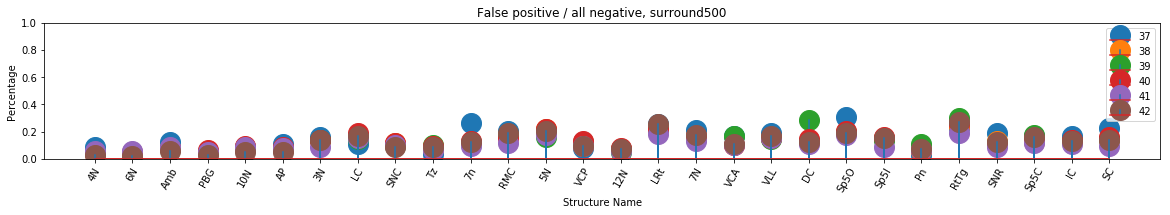

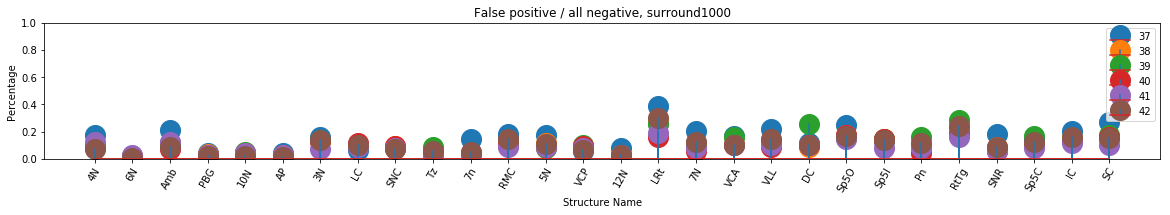

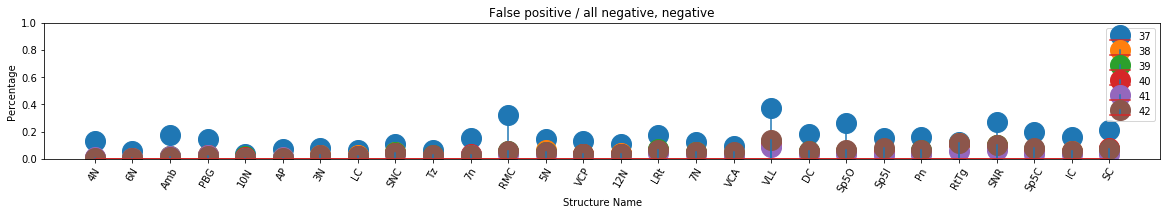

In [137]:
xticks = range(1, 1 + len(structures_sorted_by_size))

for neg_composition_rule in negative_composition_rules:

    plt.figure(figsize=(20, 2.5));
    for classifier_id in classifier_ids:
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                 [fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                  for s in structures_sorted_by_size],
                 label=classifier_id, markerfmt='o', mc=classifier_colors[classifier_id]);
#         plt.setp(markerLines, color = 'cyan', markersize = 20, markeredgecolor = 'blue', markeredgewidth = 3)
        plt.setp(markerLines, markersize = 20, alpha=1)
    plt.xticks(xticks, structures_sorted_by_size, rotation='60');
    plt.ylabel('Percentage');
    plt.xlabel('Structure Name');
    plt.title('False positive / all negative, %s' % (neg_composition_rule));
    plt.ylim([0, 1.]);
    plt.legend();
    plt.show();

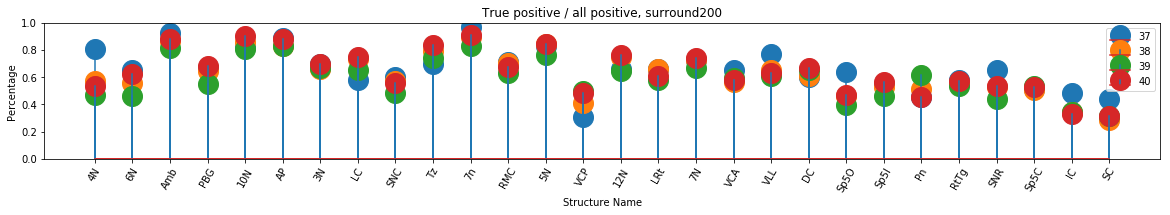

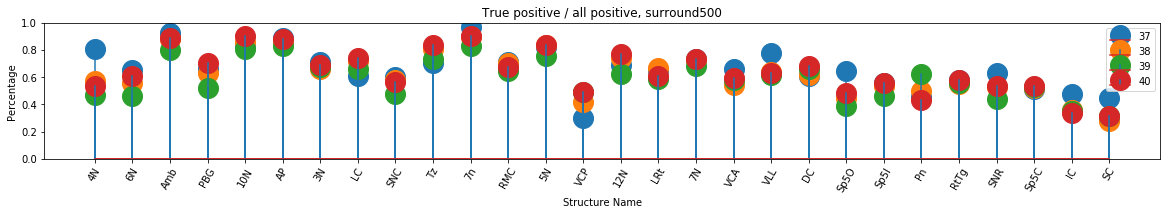

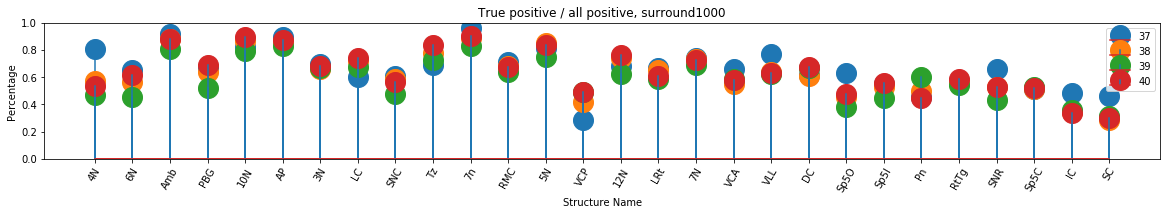

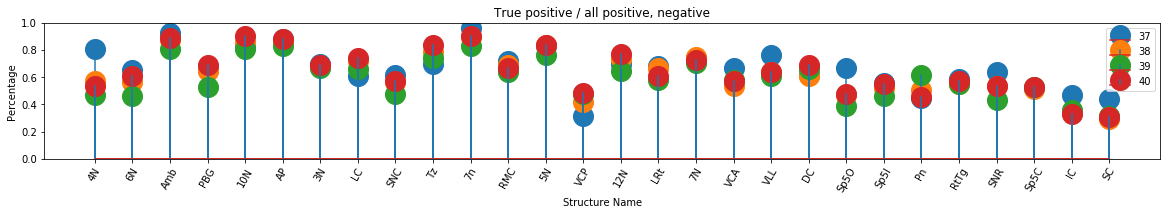

In [132]:
# TP metric only concerns positive, so should be IDENTICAL for different negcomprules.

xticks = range(1, 1 + len(structures_sorted_by_size))

for neg_composition_rule in negative_composition_rules:

    plt.figure(figsize=(20, 2.5));
    for classifier_id in classifier_ids:
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                 [tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                  for s in structures_sorted_by_size],
                 label=classifier_id, markerfmt='o', mc=classifier_colors[classifier_id]);
#         plt.setp(markerLines, color = 'cyan', markersize = 20, markeredgecolor = 'blue', markeredgewidth = 3)
        plt.setp(markerLines, markersize = 20, alpha=1.)
    plt.xticks(xticks, structures_sorted_by_size, rotation='60');
    plt.ylabel('Percentage');
    plt.xlabel('Structure Name');
    plt.title('True positive / all positive, %s' % (neg_composition_rule));
    plt.ylim([0, 1.]);
    plt.legend();
    plt.show();

# Check one classifier: Load pre-computed svm classifiers

In [45]:
classifier_id = 37

In [46]:
# # setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % classifier_id))
# setting_dir = os.path.join(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'setting_%d' % classifier_id))

In [47]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = DataManager.get_classifier_filepath(classifier_id=classifier_id, structure=structure)
    download_from_s3(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

rm -rf /shared/CSHL_classifiers/setting_37/classifiers/5N_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/5N_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/5N_clf_setting_37.dump


Child returned 0
Child returned 0
0.56 seconds.
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/6N_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/6N_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/6N_clf_setting_37.dump


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/7N_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/7N_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/7N_clf_setting_37.dump


Child returned 0
0.48 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/7n_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/7n_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/7n_clf_setting_37.dump


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/Amb_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Amb_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/Amb_clf_setting_37.dump


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/LC_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/LC_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/LC_clf_setting_37.dump


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/LRt_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/LRt_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/LRt_clf_setting_37.dump


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/Pn_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Pn_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/Pn_clf_setting_37.dump


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/Tz_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Tz_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/Tz_clf_setting_37.dump


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/VLL_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/VLL_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/VLL_clf_setting_37.dump


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/RMC_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/RMC_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/RMC_clf_setting_37.dump


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/SNC_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/SNC_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/SNC_clf_setting_37.dump


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/SNR_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/SNR_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/SNR_clf_setting_37.dump


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/3N_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/3N_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/3N_clf_setting_37.dump


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/4N_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/4N_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/4N_clf_setting_37.dump


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/Sp5I_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Sp5I_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/Sp5I_clf_setting_37.dump


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/Sp5O_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Sp5O_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/Sp5O_clf_setting_37.dump


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/Sp5C_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Sp5C_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/Sp5C_clf_setting_37.dump


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/PBG_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/PBG_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/PBG_clf_setting_37.dump


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/10N_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/10N_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/10N_clf_setting_37.dump


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/VCA_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/VCA_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/VCA_clf_setting_37.dump


Child returned 0
0.48 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/VCP_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/VCP_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/VCP_clf_setting_37.dump


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/DC_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/DC_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/DC_clf_setting_37.dump


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/AP_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/AP_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/AP_clf_setting_37.dump


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/12N_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/12N_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/12N_clf_setting_37.dump


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/RtTg_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/RtTg_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/RtTg_clf_setting_37.dump


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump


Child returned 1
0.41 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump


Child returned 1
0.38 seconds.
Classifier for outerContour is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/SC_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/SC_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/SC_clf_setting_37.dump


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/IC_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/IC_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/IC_clf_setting_37.dump


Child returned 0
0.45 seconds.


# Generate Evaluation Results

In [13]:
# eval_dir = create_if_not_exists(os.path.join(setting_dir, 'eval'))

# Compute x vs. surround accuracy

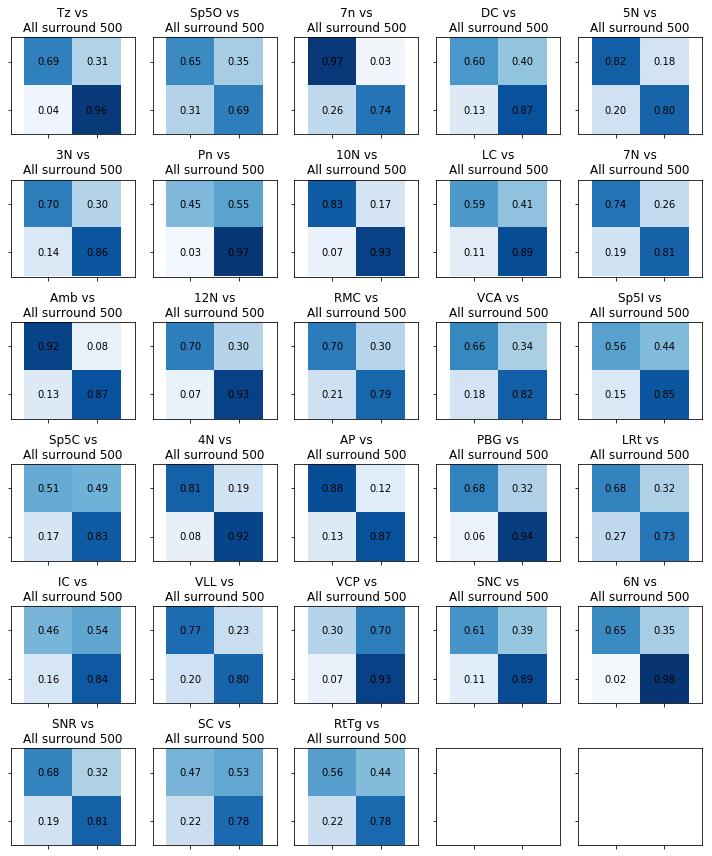

In [48]:
# Compute surround accuracy

margin = 500

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
    [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]

    neg_classes = list(set(neg_classes) & set(labels_found))
    
    features_neg = np.vstack([test_features[neg_class] for neg_class in neg_classes])
    n_neg = len(features_neg)

    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]

    if structure not in clf_allClasses:
        sys.stderr.write('Classifier for structure %s does not exist.\n' %  structure)
        continue
        
    clf = clf_allClasses[structure]

    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)

    plot_confusion_matrix(cm, title='%(structure)s vs\nAll surround %(margin)d'% {'structure':structure, 'margin':margin},
                          labels=['',''], xlabel='', ylabel='',
                         axis=axes[i])

    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[structure] = acc
        
plt.tight_layout()

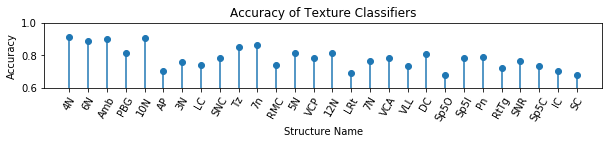

In [39]:
plt.figure(figsize=(10,1.2));
plt.stem(range(1,1+len(acc_all_structures)), [acc_all_structures[s] for s in structures_sorted_by_size]);
plt.xticks(range(1, 1+len(acc_all_structures)), structures_sorted_by_size, rotation='60');
plt.ylim([0.6, 1]);
plt.ylabel('Accuracy');
plt.xlabel('Structure Name');
plt.title('Accuracy of Texture Classifiers')
plt.show();

print 'test accuracy:', np.mean(acc_all_structures.values())

# Compute surround accuracy (margin = 200)

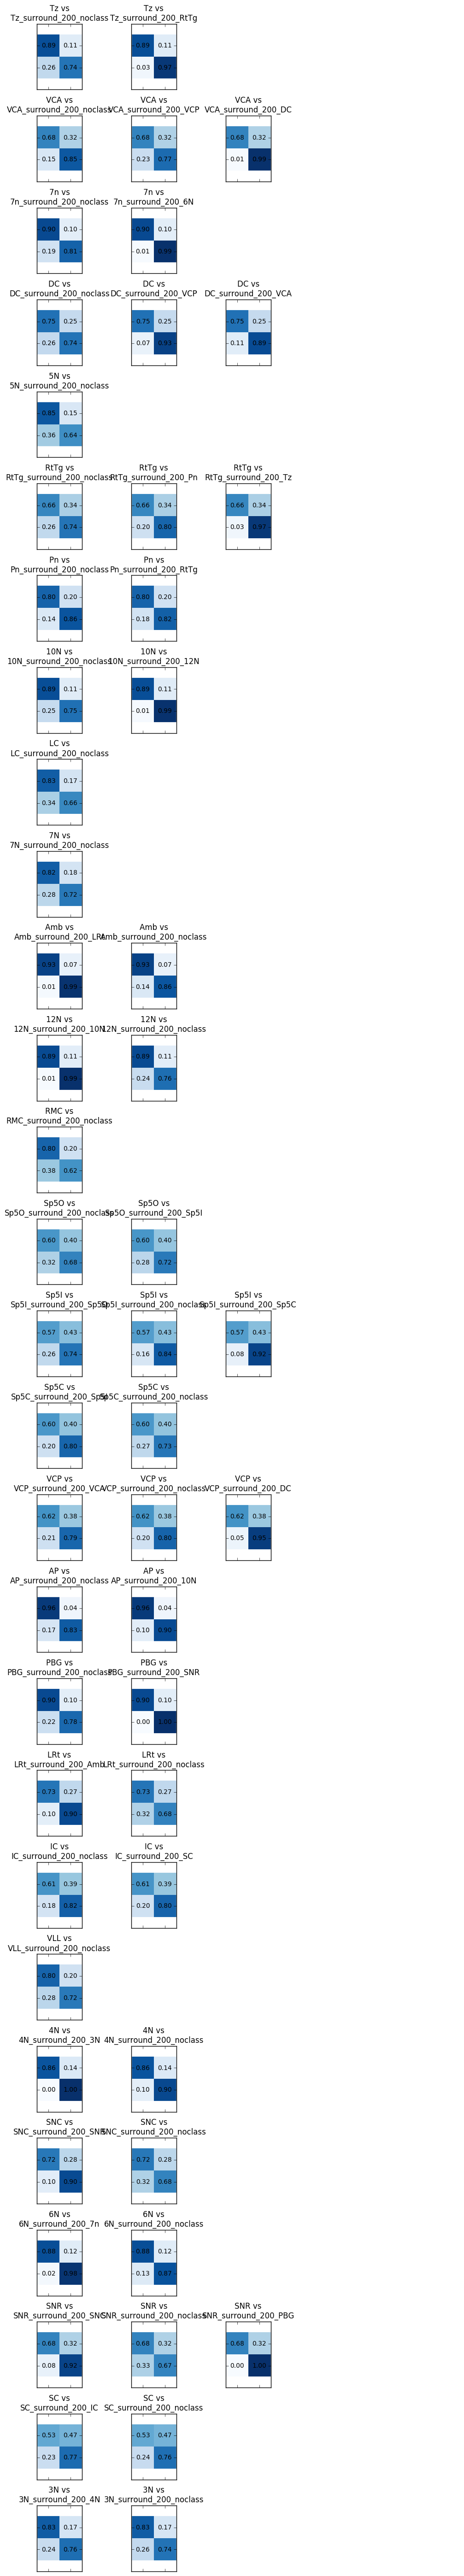

In [31]:
# Compute surround accuracy (margin = 200)

margin = 200
acc_all_pairs = {}
example_number_all_pairs = {}

ncols = 5
nrows = len(structures_found)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
# axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
    [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]

    neg_classes = list(set(neg_classes) & set(labels_found))
    
    for j, neg_class in enumerate(neg_classes):

        features_neg = test_features[neg_class]
        n_neg = len(features_neg)

        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        clf = clf_allClasses[structure]

        probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=True)

        plot_confusion_matrix(cm, title='%(structure)s vs\n%(neg_class)s'% {'structure':structure, 'neg_class': neg_class},
                              labels=['',''], xlabel='', ylabel='',
                             axis=axes[i, j])

        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=False)
        acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
        acc_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = acc
        example_number_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = n_pos + n_neg
        
    for j in range(len(neg_classes), ncols):
        axes[i,j].axis('off')

plt.tight_layout()

In [163]:
surround_cm_plot_fp = os.path.join(eval_dir, 'surround_cm_setting_%d_testset_%d.png' % (setting, dataset))
fig.savefig(surround_cm_plot_fp, bbox_inches='tight')

In [33]:
print np.sum([example_number_all_pairs[pair]*acc for pair, acc in acc_all_pairs.iteritems()])/np.sum(example_number_all_pairs.values())

0.77514253233097619

In [20]:
print np.mean(acc_all_pairs.values())

0.781163498179


In [72]:
sorted(acc_all_pairs.items(), key=lambda (x,y): y)

[('SC vs SC_surround_200_IC', 0.54535345166832483),
 ('IC vs IC_surround_200_SC', 0.63378344327912872),
 ('10N vs 10N_surround_200_noclass', 0.66050820739068417),
 ('SNC vs SNC_surround_200_noclass', 0.6633200091275756),
 ('RtTg vs RtTg_surround_200_noclass', 0.6714797206147668),
 ('6N vs 6N_surround_200_noclass', 0.68985533506809538),
 ('VCP vs VCP_surround_200_noclass', 0.69551525152803007),
 ('SNR vs SNR_surround_200_noclass', 0.69812509104994369),
 ('LC vs LC_surround_200_noclass', 0.69853481782094007),
 ('Tz vs Tz_surround_200_noclass', 0.70507607073460576),
 ('SC vs SC_surround_200_noclass', 0.71317376942676081),
 ('7N vs 7N_surround_200_noclass', 0.71696350213779547),
 ('12N vs 12N_surround_200_noclass', 0.72143003058763044),
 ('VCP vs VCP_surround_200_VCA', 0.73092031183557071),
 ('Pn vs Pn_surround_200_RtTg', 0.73416013205951769),
 ('Sp5C vs Sp5C_surround_200_noclass', 0.73950306731435578),
 ('RtTg vs RtTg_surround_200_Pn', 0.74218217411311727),
 ('VLL vs VLL_surround_200_nocl

# Compute surround accuracy for different margins

In [21]:
# Compute surround accuracy for different margins

acc_all_margins = {}

for margin in margins_to_sample:

    print 'margin = %d' % margin

    acc_all_pairs = {}

    for i, structure in enumerate(structures_found):

        features_pos = test_features[structure]
        n_pos = len(features_pos)

        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
        [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]
        
        neg_classes = list(set(neg_classes) & set(labels_found))

        for j, neg_class in enumerate(neg_classes):
    #         print 'comparing with', neg_class

            features_neg = test_features[neg_class]

            n_neg = len(features_neg)

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)

            acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
            acc_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = acc

    acc_all_margins[margin] = acc_all_pairs

margin = 200
margin = 500


In [22]:
# overall_acc_all_margins = {margin: vals['10N vs 10N_surround_%d_12N' % margin] for margin, vals in acc_all_margins.iteritems()}
overall_acc_all_margins = {margin: np.mean(vals.values()) for margin, vals in acc_all_margins.iteritems()}

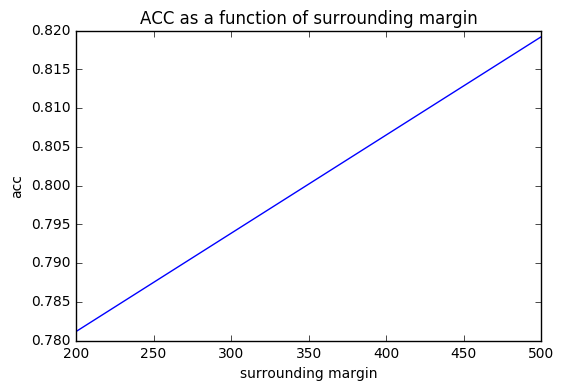

In [23]:
plt.plot(sorted(overall_acc_all_margins.keys()), 
         [overall_acc_all_margins[i] for i in sorted(overall_acc_all_margins.keys())]);
plt.xlabel('surrounding margin');
plt.ylabel('acc');
plt.title('ACC as a function of surrounding margin');

# Compute x vs. all negative accuracy

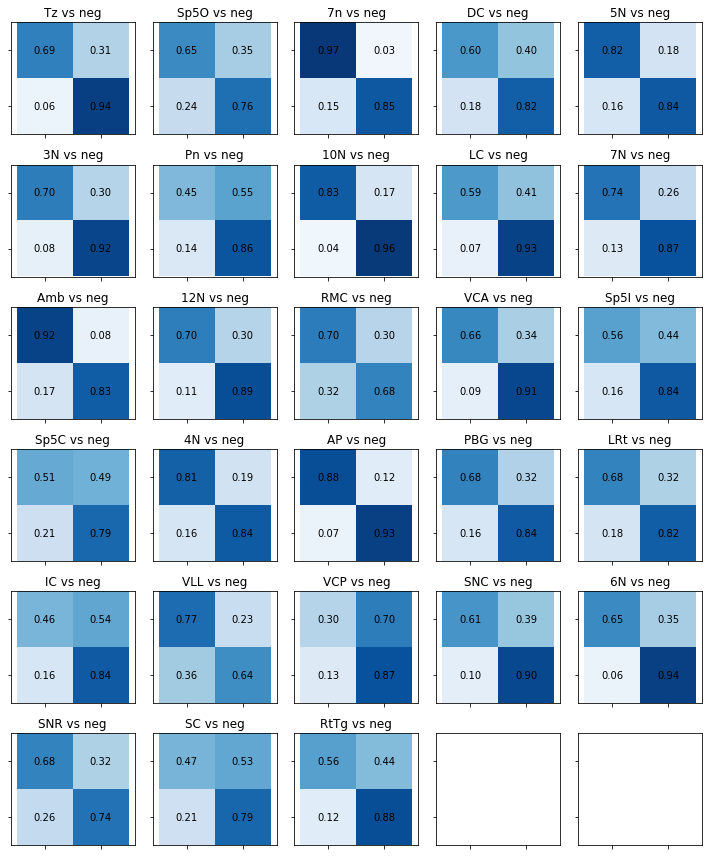

In [53]:
# Compute testing accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    features_neg = test_features[structure + '_negative']        
    n_neg = len(features_neg)
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s vs neg'% {'structure':structure},
                          labels=['',''], xlabel='', ylabel='', 
                          axis=axes[i])
    
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[structure] = acc

plt.tight_layout()

# single_vs_negative_cm_plot_fp = os.path.join(eval_dir, 'single_vs_negative_cm_setting_%d_testset_%d.png' % (setting, dataset))
# fig.savefig(single_vs_negative_cm_plot_fp, bbox_inches='tight')

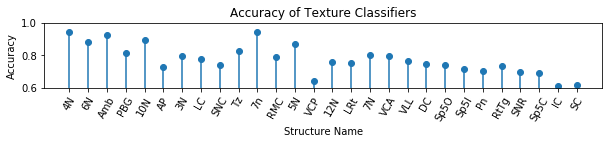

In [43]:
plt.figure(figsize=(10,1.2));
plt.stem(range(1,1+len(acc_all_structures)), [acc_all_structures[s] for s in structures_sorted_by_size]);
plt.xticks(range(1, 1+len(acc_all_structures)), structures_sorted_by_size, rotation='60');
plt.ylim([0.6, 1]);
plt.ylabel('Accuracy');
plt.xlabel('Structure Name');
plt.title('Accuracy of Texture Classifiers')
plt.show();

print 'test accuracy:', np.mean(acc_all_structures.values())

# Compute X with all surround

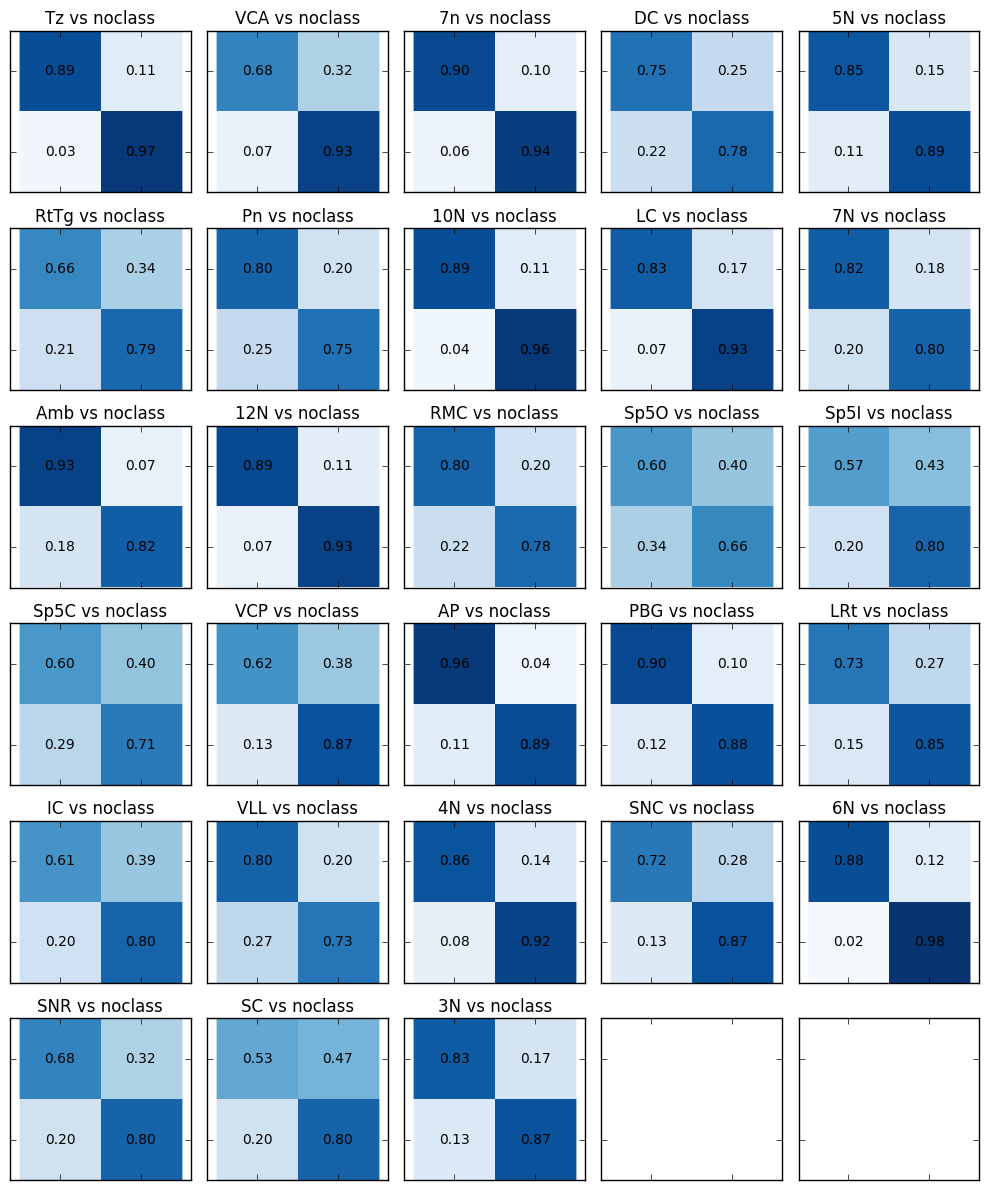

In [15]:
# Compute x vs. noclass accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    features_neg = test_features['noclass']        
    n_neg = len(features_neg)
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s vs noclass'% {'structure':structure},
                          labels=['',''], xlabel='', ylabel='', 
                          axis=axes[i])
    
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc

plt.tight_layout()


print 'test accuracy:', np.mean(acc_all_structures.values())

# single_vs_noclass_cm_plot_fp = os.path.join(eval_dir, 'single_vs_noclass_cm_setting_%d_testset_%d.png' % (setting, dataset))
# fig.savefig(single_vs_noclass_cm_plot_fp, bbox_inches='tight')

# Compute pairwise accuracy

In [76]:
# Compute pairwise accuracy

n_structures = len(structures_found)
pairwise_cm = np.zeros((n_structures, n_structures))

# for i, label in enumerate(structures):
# axes_id = 0
for i, structure in enumerate(structures_found):
    
#     print i, structure
    
    features_pos = test_features[structure]
    n_pos = len(features_pos)
        
    for j, structure2 in enumerate(structures_found):
        if i > j:
            continue
            
        if i == j:
            pairwise_cm[i,j] = 1
            continue
        
#         print 'comparing with', j, structure2
        
        features_neg = test_features[structure2]
        n_neg = len(features_neg)
        
        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        clf = clf_allClasses[structure]

        probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
        cm_sub = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)
        
#         acc = .5 * (cm_sub[0,0] + cm_sub[1,1])
        acc = (cm_sub[0,0] + cm_sub[1,1]) / (n_pos + n_neg)
        pairwise_cm[i,j] = acc
#         cm[j,i] = acc
        
#         r = np.array([i,j])
#         cm[r, r[:,None]] = acc
        
#         plot_confusion_matrix(cm_sub, title='%(label)s vs. %(label2)s'% {'label':label, 'label2':label2},
#                           labels=['',''],
# #                           labels=[label, convert_to_surround_name(label)],
#                          axis=axes[axes_id])
        
#         axes_id += 1

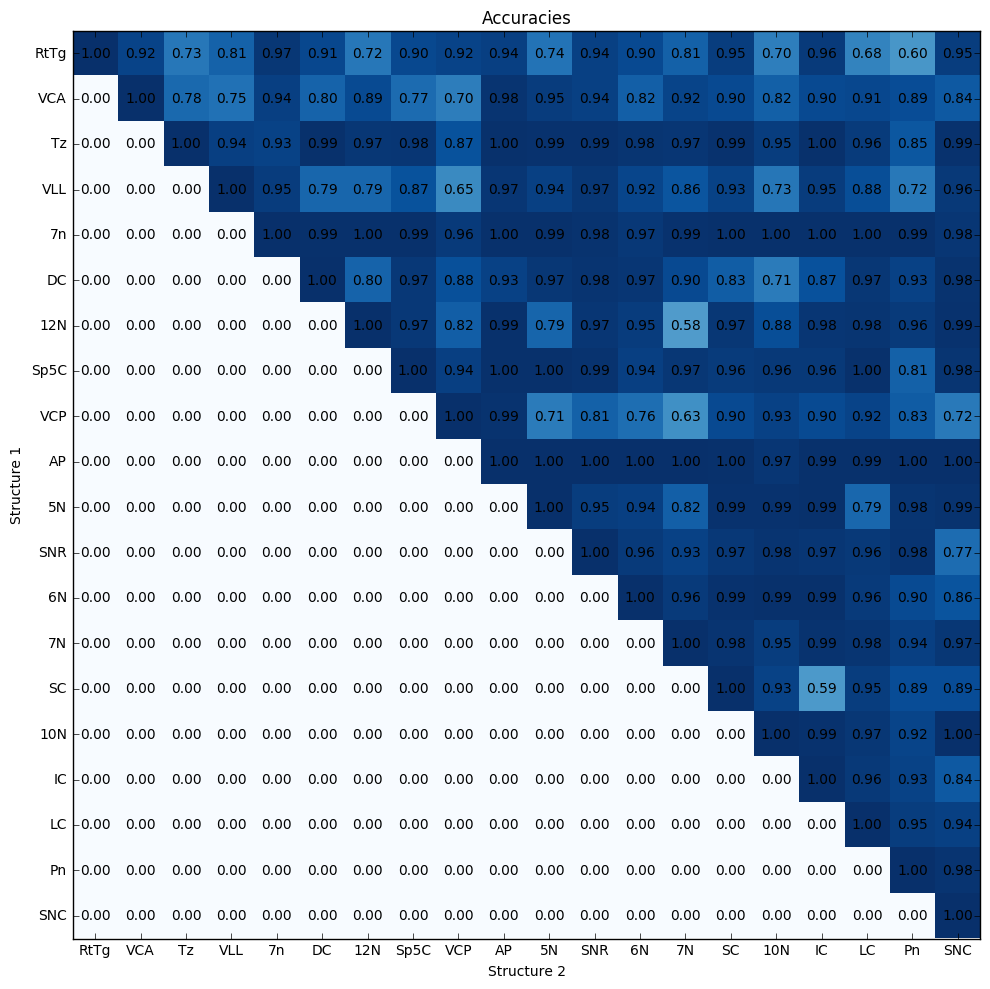

In [77]:
fig = plot_confusion_matrix(pairwise_cm, title='Accuracies',
                      labels=structures_found,
                     figsize=(10,10),
                           xlabel='Structure 2',
                           ylabel='Structure 1')

plt.tight_layout()

In [78]:
pariwise_cm_plot_fp = os.path.join(eval_dir, 'pairwise_cm_setting_%d_testset_%d.png' % (setting, dataset))
fig.savefig(pariwise_cm_plot_fp, bbox_inches='tight')